# Light GBM Random Forest - Low Depth
As part of the overall stacking model, I will develop two Random Forest (RF) models: one with a relative low depth, and one with a high depth. I define low depth as `max_depth = 5` and high depth as `max_depth = 15`. With the depth defined, I tune the remaining parameters sequentially.  
  
In this notebook, I set out to optimise a **low depth RF model** using the LightGBM package. The optimisation sequence was as follows:  
  
1. No. of Trees
2. RFECV
3. Max Features
4. Min Samples in Leaf
5. L1 Regularisation
6. L2 Regularisation
7. Subsampling
  


In [1]:
# Import modules
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.manifold import Isomap
from sklearn.metrics import accuracy_score, auc, make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RepeatedKFold, KFold, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, Normalizer, RobustScaler
from lightgbm import LGBMClassifier
import warnings

# Settings
%matplotlib inline
matplotlib.style.use('ggplot')
warnings.filterwarnings('ignore')

C:\Users\user\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Prepare Data

In [2]:
# Import data
df = pd.read_csv('train_clean.csv')

# Data and labels
X = df.drop('Survived', axis = 1)
X = pd.get_dummies(X)
y = df['Survived']

## Global Settings and Functions

In [3]:
# Repeated 5-fold validation
rkf = RepeatedStratifiedKFold(n_repeats=5, n_splits=5, random_state=123)

# Function to extract CV test results
def gaia_get_test(cv_object, params, title = 'Test Scores vs. Parameter'):
    
    # Extract test scores
    temp_test = cv_object.cv_results_['mean_test_score']
    
    # Plot
    plt.plot(params, temp_test)
    plt.title(title)
    plt.show()

## Iteration 1: Optimise No. of Trees
With `max_depth = 5`, the optimal number of trees was 1,000. Although accuracy was increasing from 2500 to 3000, this would be computationally too intensive.

In [4]:
# Define parameters
param_n_estimators = [100, 250, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
params = {
    'n_estimators': param_n_estimators
}

In [9]:
# Create RF model
rf_low = GridSearchCV(
    estimator = LGBMClassifier(
        boosting_type = 'rf',
        objective = 'binary',
        subsample = 0.632,
        subsample_freq = 1,
        max_depth = 5,
        # n_estimators = ,
        colsample_bytree = 0.5,
        # min_child_samples = ,
        # reg_alpha = ,
        # reg_lambda = ,
        random_state = 123,
        n_jobs = 3
    ),
    param_grid = params,
    n_jobs = 3,
    cv = rkf,
    verbose = 1
)

# Train model
rf_low.fit(X, y)

Fitting 25 folds for each of 10 candidates, totalling 250 fits


[Parallel(n_jobs=3)]: Done  26 tasks      | elapsed:    4.4s
[Parallel(n_jobs=3)]: Done 122 tasks      | elapsed:   36.9s
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  3.7min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x000002328CAF8D68>,
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='rf', class_weight=None, colsample_bytree=0.5,
        learning_rate=0.1, max_depth=5, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=3, num_leaves=31, objective='binary', random_state=123,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.632,
        subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'n_estimators': [100, 250, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [10]:
# Print results
print('Best Score: ' + str(rf_low.best_score_))
print('Best Params: ' + str(rf_low.best_params_))

Best Score: 0.8184062850729518
Best Params: {'n_estimators': 2500}


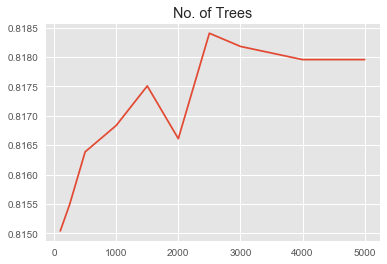

In [11]:
# Plot results
gaia_get_test(rf_low, param_n_estimators, 'No. of Trees')

## Iteration 2: Run RFECV

In [13]:
# Create model
rf_low = RFECV(
    estimator = LGBMClassifier(
        boosting_type = 'rf',
        objective = 'binary',
        subsample = 0.632,
        subsample_freq = 1,
        min_split_gain = 0,
        max_depth = 5,
        n_estimators = 2500,
        colsample_bytree = 0.5,
        # min_child_samples = ,
        # reg_alpha = ,
        # reg_lambda = ,
        random_state = 123,
        n_jobs = 3
    ),
    cv = rkf,
    verbose = 1,
    n_jobs = 1
)

# Fit model
rf_low.fit(X, y)

RFECV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x000002328CAF8D68>,
   estimator=LGBMClassifier(boosting_type='rf', class_weight=None, colsample_bytree=0.5,
        learning_rate=0.1, max_depth=5, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0, n_estimators=2500,
        n_jobs=3, num_leaves=31, objective='binary', random_state=123,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.632,
        subsample_for_bin=200000, subsample_freq=1),
   n_jobs=3, scoring=None, step=1, verbose=2)

In [14]:
# Results of RFE
print('No. of Features: ' + str(rf_low.n_features_))
print('Feature Ranking:')
rfe_feats = pd.DataFrame(rf_low.ranking_, columns = ['rank'])
rfe_feats['feature'] = X.columns
rfe_feats.sort_values(by = 'rank')

No. of Features: 26
Feature Ranking:


,rank,feature
0,1,pclass_OC
49,1,cabno_OH_C1
41,1,ticlen_OH_L6
40,1,ticlen_OH_L5
32,1,age_OH_A3
31,1,age_OH_A2
28,1,sex_OH_female
25,1,title_OH_Mr.
22,1,pclass_OH_CLASS3
19,1,embarked_ME


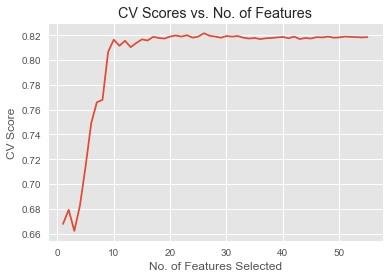

In [15]:
# Plots
plt.figure()
plt.title('CV Scores vs. No. of Features')
plt.xlabel("No. of Features Selected")
plt.ylabel("CV Score")
plt.plot(range(1, len(rf_low.grid_scores_) + 1), rf_low.grid_scores_)
plt.show()

## Subset Features

In [16]:
# Subset features
X_sub = X.iloc[:, (rf_low.ranking_ == 1)]

## Iteration 3: Optimise Max Features

In [24]:
# Define parameters
param_max_feat = np.arange(2/X_sub.shape[1], 1, 1/X_sub.shape[1])
params = {
    'colsample_bytree': param_max_feat
}

In [25]:
# Create RF model
rf_low = GridSearchCV(
    estimator = LGBMClassifier(
        boosting_type = 'rf',
        objective = 'binary',
        subsample = 0.632,
        subsample_freq = 1,
        max_depth = 5,
        n_estimators = 2500,
        # min_child_samples = ,
        # reg_alpha = ,
        # reg_lambda = ,
        random_state = 123,
        n_jobs = 3
    ),
    param_grid = params,
    n_jobs = 3,
    cv = rkf,
    verbose = 1
)

# Train model
rf_low.fit(X_sub, y)

Fitting 25 folds for each of 24 candidates, totalling 600 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   34.5s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.0min
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:  7.7min
[Parallel(n_jobs=3)]: Done 600 out of 600 | elapsed: 10.7min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x000002328CAF8D68>,
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='rf', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=5, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=2500,
        n_jobs=3, num_leaves=31, objective='binary', random_state=123,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=0.632,
        subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'colsample_bytree': array([0.07692, 0.11538, 0.15385, 0.19231, 0.23077, 0.26923, 0.30769,
       0.34615, 0.38462, 0.42308, 0.46154, 0.5    , 0.53846, 0.57692,
       0.61538, 0.65385, 0.69231, 0.73077, 0.76923, 0.80769, 0.84615,
       0.88462, 0.92308, 0.96154])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [26]:
# Print results
print('Best Score: ' + str(rf_low.best_score_))
print('Best Params: ' + str(rf_low.best_params_))

Best Score: 0.8224466891133558
Best Params: {'colsample_bytree': 0.2692307692307693}


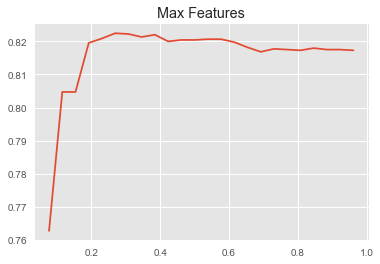

In [27]:
# Plot results
gaia_get_test(rf_low, param_max_feat, 'Max Features')

### Iteration 4: Optimise Minimum Samples in Terminal Nodes

In [33]:
# Define parameters
param_min_leaf = [1,5,10,20,30,40,50]
params = {
    'min_child_samples': param_min_leaf
}

In [32]:
7/X_sub.shape[1]

0.2692307692307692

In [34]:
# Create RF model
rf_low = GridSearchCV(
    estimator = LGBMClassifier(
        boosting_type = 'rf',
        objective = 'binary',
        subsample = 0.632,
        subsample_freq = 1,
        max_depth = 5,
        n_estimators = 2500,
        colsample_bytree = 7/X_sub.shape[1],
        # min_child_samples = ,
        # reg_alpha = ,
        # reg_lambda = ,
        random_state = 123,
        n_jobs = 3
    ),
    param_grid = params,
    n_jobs = 3,
    cv = rkf,
    verbose = 1
)

# Train model
rf_low.fit(X_sub, y)

Fitting 25 folds for each of 7 candidates, totalling 175 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:  1.1min
[Parallel(n_jobs=3)]: Done 175 out of 175 | elapsed:  3.2min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x000002328CAF8D68>,
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='rf', class_weight=None,
        colsample_bytree=0.2692307692307692, learning_rate=0.1,
        max_depth=5, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=2500, n_jobs=3, num_leaves=31,
        objective='binary', random_state=123, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=0.632,
        subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'min_child_samples': [1, 5, 10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [35]:
# Print results
print('Best Score: ' + str(rf_low.best_score_))
print('Best Params: ' + str(rf_low.best_params_))

Best Score: 0.8316498316498316
Best Params: {'min_child_samples': 1}


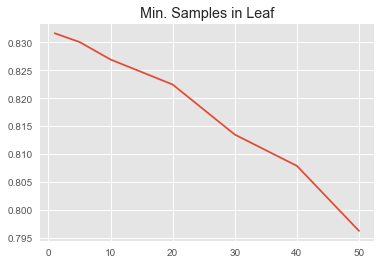

In [36]:
# Plot results
gaia_get_test(rf_low, param_min_leaf, 'Min. Samples in Leaf')

### Iteration 5: Optimise L1 Regularisation

In [47]:
# Define parameters
param_alpha = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
params = {
    'reg_alpha': param_alpha
}

In [48]:
# Create RF model
rf_low = GridSearchCV(
    estimator = LGBMClassifier(
        boosting_type = 'rf',
        objective = 'binary',
        subsample = 0.632,
        subsample_freq = 1,
        max_depth = 5,
        n_estimators = 2500,
        colsample_bytree = 7/X_sub.shape[1],
        min_child_samples = 1,
        # reg_alpha = ,
        # reg_lambda = ,
        random_state = 123,
        n_jobs = 3
    ),
    param_grid = params,
    n_jobs = 3,
    cv = rkf,
    verbose = 1
)

# Train model
rf_low.fit(X_sub, y)

Fitting 25 folds for each of 10 candidates, totalling 250 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   53.3s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.6min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  4.3min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x000002328CAF8D68>,
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='rf', class_weight=None,
        colsample_bytree=0.2692307692307692, learning_rate=0.1,
        max_depth=5, min_child_samples=1, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=2500, n_jobs=3, num_leaves=31,
        objective='binary', random_state=123, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=0.632,
        subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [49]:
# Print results
print('Best Score: ' + str(rf_low.best_score_))
print('Best Params: ' + str(rf_low.best_params_))

Best Score: 0.8318742985409652
Best Params: {'reg_alpha': 0.1}


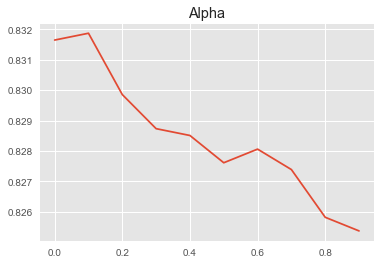

In [50]:
# Plot results
gaia_get_test(rf_low, param_alpha, 'Alpha')

### Iteration 6: Optimise L2 Regularisation

In [51]:
# Define parameters
param_lambda = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
params = {
    'reg_lambda': param_lambda
}

In [52]:
# Create RF model
rf_low = GridSearchCV(
    estimator = LGBMClassifier(
        boosting_type = 'rf',
        objective = 'binary',
        subsample = 0.632,
        subsample_freq = 1,
        max_depth = 5,
        n_estimators = 2500,
        colsample_bytree = 7/X_sub.shape[1],
        min_child_samples = 1,
        reg_alpha = 0.1,
        # reg_lambda = ,
        random_state = 123,
        n_jobs = 3
    ),
    param_grid = params,
    n_jobs = 3,
    cv = rkf,
    verbose = 1
)

# Train model
rf_low.fit(X_sub, y)

Fitting 25 folds for each of 10 candidates, totalling 250 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   48.8s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.6min
[Parallel(n_jobs=3)]: Done 250 out of 250 | elapsed:  4.5min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x000002328CAF8D68>,
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='rf', class_weight=None,
        colsample_bytree=0.2692307692307692, learning_rate=0.1,
        max_depth=5, min_child_samples=1, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=2500, n_jobs=3, num_leaves=31,
        objective='binary', random_state=123, reg_alpha=0.1,
        reg_lambda=0.0, silent=True, subsample=0.632,
        subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'reg_lambda': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [53]:
# Print results
print('Best Score: ' + str(rf_low.best_score_))
print('Best Params: ' + str(rf_low.best_params_))

Best Score: 0.8318742985409652
Best Params: {'reg_lambda': 0}


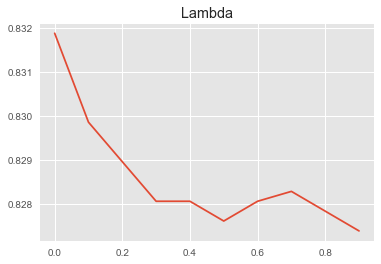

In [54]:
# Plot results
gaia_get_test(rf_low, param_lambda, 'Lambda')

### Iteration 7: Optimise Subsampling

In [55]:
# Define parameters
param_subsample = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
params = {
    'subsample': param_subsample
}

In [57]:
# Create RF model
rf_low = GridSearchCV(
    estimator = LGBMClassifier(
        boosting_type = 'rf',
        objective = 'binary',
        subsample = 0.9,
        subsample_freq = 1,
        max_depth = 5,
        n_estimators = 2500,
        colsample_bytree = 7/X_sub.shape[1],
        min_child_samples = 1,
        reg_alpha = 0.1,
        reg_lambda = 0,
        random_state = 123,
        n_jobs = 3
    ),
    param_grid = params,
    n_jobs = 3,
    cv = rkf,
    verbose = 1
)

# Train model
rf_low.fit(X_sub, y)

Fitting 25 folds for each of 8 candidates, totalling 200 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   48.0s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:  3.8min
[Parallel(n_jobs=3)]: Done 200 out of 200 | elapsed:  4.0min finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedStratifiedKFold object at 0x000002328CAF8D68>,
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='rf', class_weight=None,
        colsample_bytree=0.2692307692307692, learning_rate=0.1,
        max_depth=5, min_child_samples=1, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=2500, n_jobs=3, num_leaves=31,
        objective='binary', random_state=123, reg_alpha=0.1, reg_lambda=0,
        silent=True, subsample=1.0, subsample_for_bin=200000,
        subsample_freq=1),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'subsample': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [58]:
# Print results
print('Best Score: ' + str(rf_low.best_score_))
print('Best Params: ' + str(rf_low.best_params_))

Best Score: 0.8332210998877666
Best Params: {'subsample': 0.9}


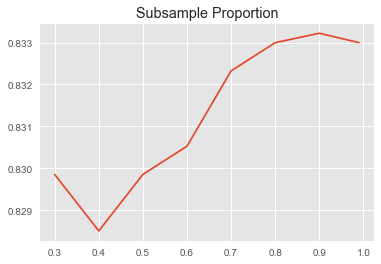

In [59]:
# Plot results
gaia_get_test(rf_low, param_subsample, 'Subsample Proportion')